In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import datetime as dt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,Add,Activation
from keras import backend as K
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

169009152/169001437 [==============================] - 30s 0us/step


In [ ]:
y_proc=np.zeros((50000,100))
for i in range(0,50000):
    y_proc[i][y_train[i][0]]=1
y_test_proc=np.zeros((10000,100))
for i in range(0,10000):
    y_test_proc[i][y_test[i][0]]=1
y_proc.shape
input_shape=(32,32,3)

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [ ]:
def res_net_block(input_data, filters, conv_size):
  x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
  x = layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
  x = layers.Add()([x, input_data])
  x = layers.Activation('relu')(x)
  return x

In [ ]:
inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
num_res_net_blocks = 5
filters=32
conv_size=3

x_skip=x
x = layers.Conv2D(32, conv_size, activation='relu', padding='same')(x)

x = layers.Add()([x, x_skip])
# x = layers.MaxPool2D((3,3), strides=(1,1), padding='same')(x)
x = layers.Activation('relu')(x)

x_skip=x
x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(x)
x = layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
x = layers.Add()([x, x_skip])
# x = layers.MaxPool2D((3,3), strides=(1,1), padding='same')(x)
x = layers.Activation('relu')(x)
x=layers.Dropout(0.01)(x)

x_skip=x
x = layers.Conv2D(32, conv_size, activation='relu', padding='same')(x)
x = layers.Conv2D(32, conv_size, activation=None, padding='same')(x)
x = layers.Add()([x, x_skip])
# x = layers.MaxPool2D((3,3), strides=(1,1), padding='same')(x)
x = layers.Activation('relu')(x)

x = layers.Conv2D(64, conv_size, activation=None, padding='same')(x)

x_skip=x
x = layers.Conv2D(64, conv_size, activation='relu', padding='same')(x)
x = layers.Conv2D(64, conv_size, activation=None, padding='same')(x)
x = layers.Add()([x, x_skip])
# x = layers.MaxPool2D((3,3), strides=(1,1), padding='same')(x)
x = layers.Activation('relu')(x)

x_skip=x
x = layers.Conv2D(64, conv_size, activation='relu', padding='same')(x)
x = layers.Conv2D(64, conv_size, activation=None, padding='same')(x)
x = layers.Add()([x, x_skip])
# x = layers.MaxPool2D((3,3), strides=(1,1), padding='same')(x)
x = layers.Activation('relu')(x)
x=layers.Dropout(0.01)(x)
x = layers.Conv2D(128, conv_size, activation=None, padding='same')(x)

x_skip=x
x = layers.Conv2D(128, conv_size, activation='relu', padding='same')(x)
x = layers.Conv2D(128, conv_size, activation=None, padding='same')(x)
x = layers.Add()([x, x_skip])
# x = layers.MaxPool2D((3,3), strides=(1,1), padding='same')(x)
x = layers.Activation('relu')(x)

x_skip=x
x = layers.Conv2D(128, conv_size, activation='relu', padding='same')(x)
x = layers.Conv2D(128, conv_size, activation=None, padding='same')(x)
x = layers.Add()([x, x_skip])
# x = layers.MaxPool2D((3,3), strides=(1,1), padding='same')(x)
x = layers.Activation('relu')(x)
x=layers.Dropout(0.01)(x)

x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.AveragePooling2D(4)(x)
x=layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(100, activation='softmax')(x)

res_net_model = keras.Model(inputs, outputs)

In [ ]:
res_net_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 9, 9, 32)     0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [ ]:
%load_ext tensorboard
tensor_board = tf.keras.callbacks.TensorBoard(log_dir='tensorboard',histogram_freq=1)
res_net_model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,min_delta=0.00000001)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='resnet_adam_dropout.hdf5',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
# res_net_model.fit(x_train,y_proc,batch_size=128,validation_data=(x_test,y_test_proc),epochs=100,callbacks=[callback,model_checkpoint_callback])
output=res_net_model.fit_generator(datagen.flow(x_train,y_proc,batch_size = 200), epochs = 100, validation_data = (x_test,y_test_proc),callbacks = [tensor_board,callback,model_checkpoint_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
  1/250 [..............................] - ETA: 0s - loss: 23.9895 - acc: 0.0100WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
250/250 [==============================] - 25s 101ms/step - loss: 4.7704 - acc: 0.0188 - val_loss: 4.2422 - val_acc: 0.0420
Epoch 2/100
250/250 [==============================] - 25s 99ms/step - loss: 4.0954 - acc: 0.0599 - val_loss: 3.9033 - val_acc: 0.0906
Epoch 3/100
250/250 [==============================] - 25s 99ms/step - loss: 3.8120 - acc: 0.1033 - val_loss: 3.6320 - val_acc: 0.1323
Epoch 4/100
250/250 [==============================] - 25s 99ms/step - loss: 3.5394 - acc: 0.1504 - val_loss: 3.3242 - val_acc: 0.1892
Epoch 5/100
250/250 [====

In [ ]:

y_pred=res_net_model.predict(x_test)
# tf.one_hot(y_pred)
# y_pred=np.where(y_pred[0]=max(y_pred[0],1,0))
y_pred_proc=np.zeros((10000,100))
for i in range(0,10000):
    y_pred_proc[i][np.argmax(y_pred[i])]=1
print("Precision: "+ str(precision_score(y_test_proc, y_pred_proc, average='weighted')))
print("Recall: "+ str(recall_score(y_test_proc, y_pred_proc, average='weighted')))
print("Accuracy: "+ str(accuracy_score(y_test_proc, y_pred_proc)))

Precision: 0.5310182272184288
Recall: 0.5025
Accuracy: 0.5025


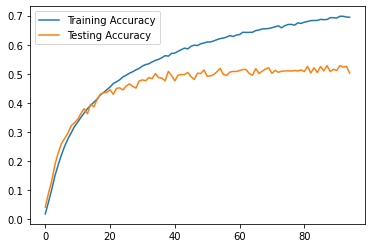

In [ ]:
plt.plot(output.history['acc'])
plt.plot(output.history['val_acc'])
plt.legend(['Training Accuracy','Testing Accuracy'])


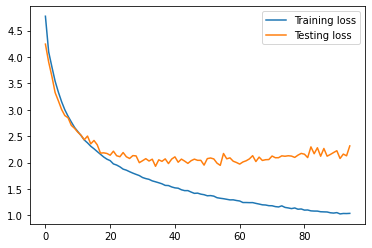

In [ ]:
plt.plot(output.history['loss'])
plt.plot(output.history['val_loss'])
plt.legend(['Training loss','Testing loss'])

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import datetime as dt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,Add,Activation
from keras import backend as K
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

y_proc=np.zeros((50000,100))
for i in range(0,50000):
    y_proc[i][y_train[i][0]]=1
y_test_proc=np.zeros((10000,100))
for i in range(0,10000):
    y_test_proc[i][y_test[i][0]]=1
y_proc.shape
input_shape=(32,32,3)

inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
num_res_net_blocks = 5
filters=32
conv_size=3

x_skip=x
x = layers.Conv2D(32, conv_size, activation='relu', padding='same')(x)

x = layers.Add()([x, x_skip])
# x = layers.MaxPool2D((3,3), strides=(1,1), padding='same')(x)
x = layers.Activation('relu')(x)

x_skip=x
x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(x)
x = layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
x = layers.Add()([x, x_skip])
# x = layers.MaxPool2D((3,3), strides=(1,1), padding='same')(x)
x = layers.Activation('relu')(x)
x=layers.Dropout(0.01)(x)

x_skip=x
x = layers.Conv2D(32, conv_size, activation='relu', padding='same')(x)
x = layers.Conv2D(32, conv_size, activation=None, padding='same')(x)
x = layers.Add()([x, x_skip])
# x = layers.MaxPool2D((3,3), strides=(1,1), padding='same')(x)
x = layers.Activation('relu')(x)

x = layers.Conv2D(64, conv_size, activation=None, padding='same')(x)

x_skip=x
x = layers.Conv2D(64, conv_size, activation='relu', padding='same')(x)
x = layers.Conv2D(64, conv_size, activation=None, padding='same')(x)
x = layers.Add()([x, x_skip])
# x = layers.MaxPool2D((3,3), strides=(1,1), padding='same')(x)
x = layers.Activation('relu')(x)

x_skip=x
x = layers.Conv2D(64, conv_size, activation='relu', padding='same')(x)
x = layers.Conv2D(64, conv_size, activation=None, padding='same')(x)
x = layers.Add()([x, x_skip])
# x = layers.MaxPool2D((3,3), strides=(1,1), padding='same')(x)
x = layers.Activation('relu')(x)
x=layers.Dropout(0.01)(x)
x = layers.Conv2D(128, conv_size, activation=None, padding='same')(x)

x_skip=x
x = layers.Conv2D(128, conv_size, activation='relu', padding='same')(x)
x = layers.Conv2D(128, conv_size, activation=None, padding='same')(x)
x = layers.Add()([x, x_skip])
# x = layers.MaxPool2D((3,3), strides=(1,1), padding='same')(x)
x = layers.Activation('relu')(x)

x_skip=x
x = layers.Conv2D(128, conv_size, activation='relu', padding='same')(x)
x = layers.Conv2D(128, conv_size, activation=None, padding='same')(x)
x = layers.Add()([x, x_skip])
# x = layers.MaxPool2D((3,3), strides=(1,1), padding='same')(x)
x = layers.Activation('relu')(x)
x=layers.Dropout(0.01)(x)

x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.AveragePooling2D(4)(x)
x=layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(100, activation='softmax')(x)

res_net_model = keras.Model(inputs, outputs)

res_net_model.load_weights('../weights/resnet_adam_dropout.hdf5')


y_pred=res_net_model.predict(x_test)
# tf.one_hot(y_pred)
# y_pred=np.where(y_pred[0]=max(y_pred[0],1,0))
y_pred_proc=np.zeros((10000,100))
for i in range(0,10000):
    y_pred_proc[i][np.argmax(y_pred[i])]=1
print("Precision: "+ str(precision_score(y_test_proc, y_pred_proc, average='weighted')))
print("Recall: "+ str(recall_score(y_test_proc, y_pred_proc, average='weighted')))
print("Accuracy: "+ str(accuracy_score(y_test_proc, y_pred_proc)))

169009152/169001437 [==============================] - 4s 0us/step
Precision: 0.5481367202351054
Recall: 0.5283
Accuracy: 0.5283
